https://github.com/facebookresearch/fairseq/tree/main/examples/roberta/commonsense_qa#3-evaluate

# NLP FS25 Course Project 2: Commensense Question Answering with Transformers

By David Hodel

Weighs & Biases Project: https://wandb.ai/dhodel-hslu-nlp/hslu-fs25-nlp-qa-transformers

## Introduction

In this notebook, I present my solution to the second course project of the FS25 NLP module at HSLU.

The task is to compare three Transformer models on the task of commonsense question answering:
1) A randomly initialized Transformer
2) A pre-trained Transformer (which was not trained / finetuned on CommonsenseQA)
3) An LLM (1B+ parameters) of my choice

I'll finetune the first two models and do prompt-engineering for the LLM. The goal is to compare the performance of these three models on the task of commonsense question answering.

### Dataset

We use the CommonsenseQA ([Talmor et al., 2019](https://aclanthology.org/N19-1421/)) dataset in this project. The dataset consists of 12,247 questions with 5 choices each, where only one is correct. The questions are designed to require commonsense reasoning to answer correctly.

The dataset was created by taking concepts from ConceptNet, a semantic network of commonsense knowledge.

## Setup

We first import the necessary libraries to run the code.

In [1]:
from collections import Counter
from datetime import datetime

from datasets import load_dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torcheval.metrics as metrics
from transformers import AutoTokenizer, AutoModel, AutoConfig

import torch
import wandb

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

We set up a fixed random seed to (at least try to) ensure reproducibility.

In [2]:
SEED = 42
seed_everything(SEED, workers=True)

Seed set to 42


42

Since we use Weights & Biases for experiment tracking, we first have to log in to our account.

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: davidhodel (waitless-hslu-dspro2-fs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Data Splits

The data is available on Hugging Face: https://huggingface.co/datasets/tau/commonsense_qa.
Since only the train and validation splits have an answer key, we will use our own dataset splits.
We perform the splitting as presented in the lecture slides. We separate the last 1"000 samples from the training set as the validation set and use the original validation set as the test set.

In [4]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## Data Exploration

First, we want to take a look at the data to understand its structure and content.

In [5]:
datasets = {
  "train": train,
  "validation": valid,
  "test": test
}

We ensure that all three splits have the same structure and that the answers are in the same format.

In [6]:
print(train.column_names)
assert train.column_names == valid.column_names == test.column_names

print(train[0])

unique_answers = set([ex["answerKey"] for ex in train] + [ex["answerKey"] for ex in valid] + [ex["answerKey"] for ex in test])
print(f"Unique answer keys: {unique_answers}")

assert len(unique_answers) == 5

['id', 'question', 'question_concept', 'choices', 'answerKey']
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}
Unique answer keys: {'A', 'E', 'B', 'C', 'D'}


We then display a sample question and its answer for each split to get a feeling of the type of questions and answers.

In [7]:
for split, data in datasets.items():
    print(f"\n=== {split} Split ===")
    print(f"Question: {data[0]['question']}")
    for j, choice in enumerate(data[0]['choices']['text']):
        print(f"{chr(65+j)}) {choice}")  # A, B, C, etc.
    print(f"Correct Answer: {data[0]['answerKey']}")
    print("=" * 50)


=== train Split ===
Question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
A) ignore
B) enforce
C) authoritarian
D) yell at
E) avoid
Correct Answer: A

=== validation Split ===
Question: What is a well known way for couples  of celebrating a marriage?
A) eat cake
B) getting drunk
C) having sex
D) cleaning rooms
E) drink too much
Correct Answer: C

=== test Split ===
Question: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what?
A) bank
B) library
C) department store
D) mall
E) new york
Correct Answer: A


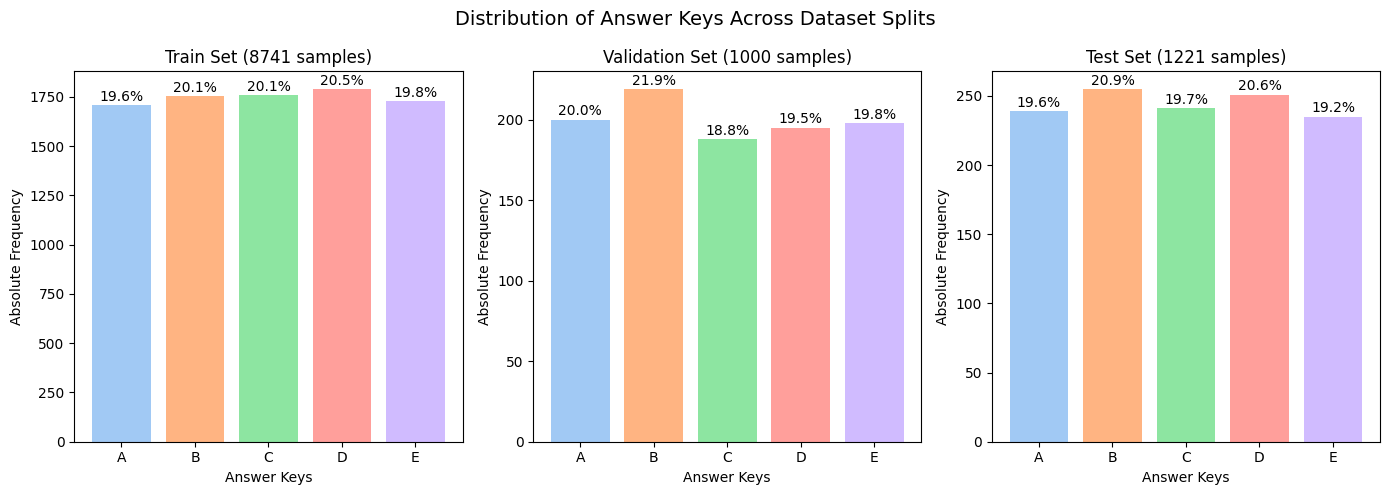

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

labels = sorted(list(unique_answers))

colors = sns.color_palette("pastel")[0:5]

for i, (split, data) in enumerate(datasets.items()):
    answer_counts = Counter([ex["answerKey"] for ex in data])
    
    # Sort by labels to ensure consistent order
    counts = [answer_counts[label] for label in labels]
    
    ax[i].bar(labels, counts, color=colors)
    ax[i].set_xlabel("Answer Keys")
    ax[i].set_ylabel("Absolute Frequency")
    ax[i].set_title(f"{split.capitalize()} Set ({len(data)} samples)")
    
    # Add percentage annotations
    total = sum(counts)
    for j, count in enumerate(counts):
        percentage = count / total * 100
        ax[i].annotate(f"{percentage:.1f}%", 
                      xy=(labels[j], count),
                      xytext=(0, 3),
                      textcoords="offset points",
                      ha='center')

plt.suptitle("Distribution of Answer Keys Across Dataset Splits", fontsize=14)
plt.tight_layout()

We see that the distribution is relatively balanced, with a slight preference for answer `B` in the validation and test set.

We also plot the distribution of the number of characters in the questions.

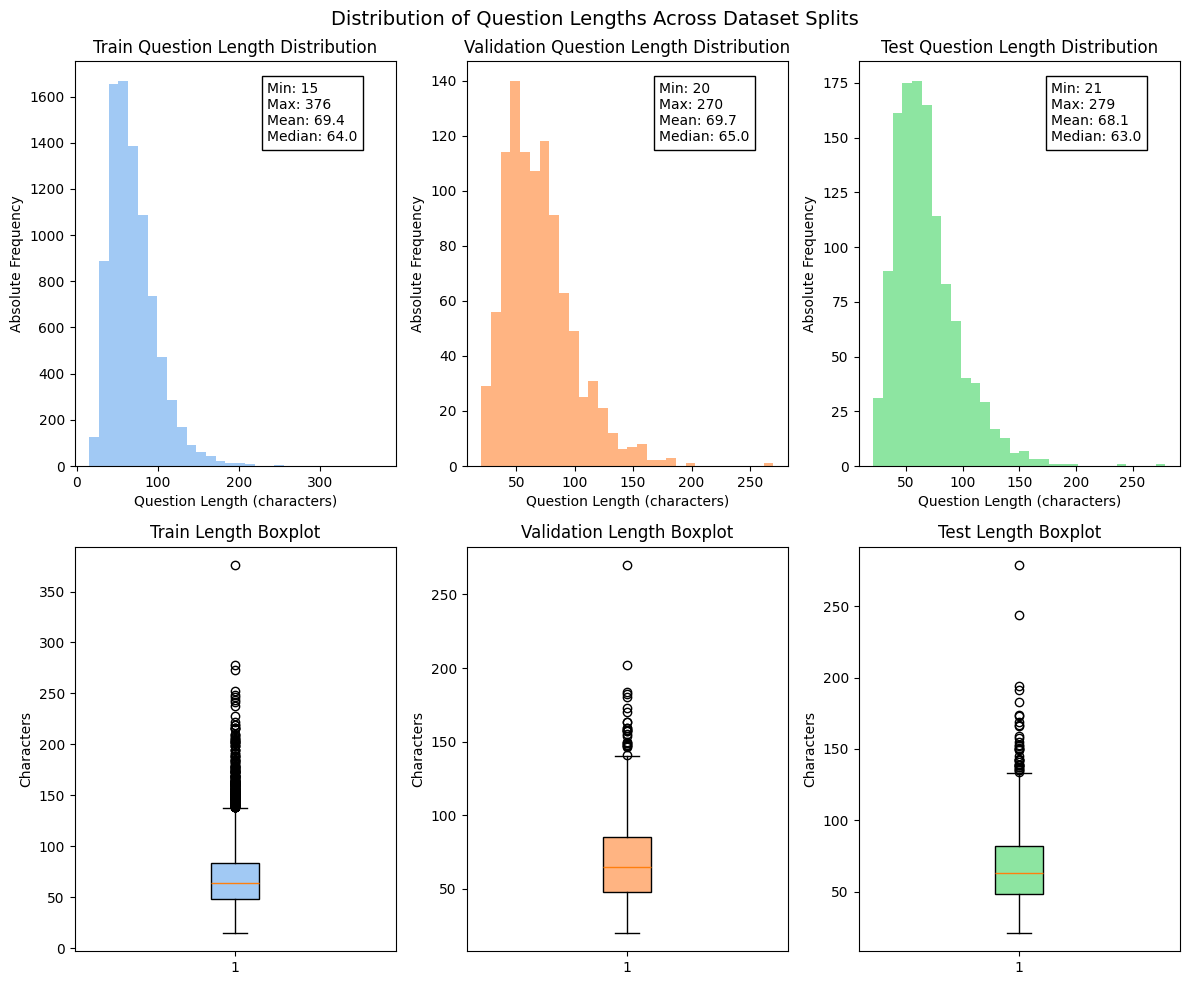

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_question_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  question_lengths = [len(ex["question"]) for ex in data]
  all_question_lengths.append(question_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(question_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Question Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Question Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(question_lengths)}\nMax: {max(question_lengths)}\nMean: {np.mean(question_lengths):.1f}\nMedian: {np.median(question_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(question_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Question Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

We see that the questions are relatively short, with most of them having less than 100 characters. The three splits have a similar distribution and similar mean and median values.

The longest question has 376 characters which is good managable for a transformer model.

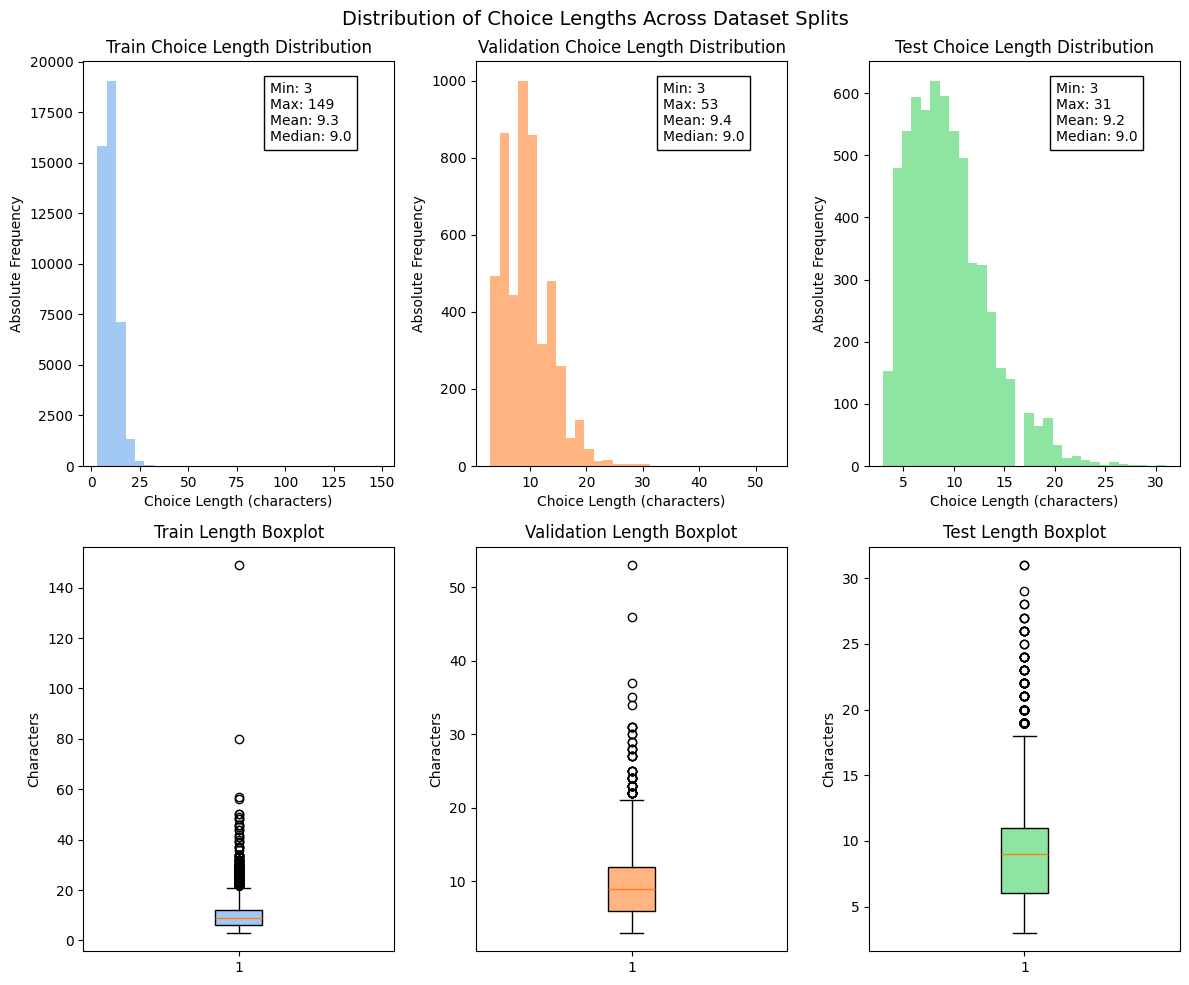

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

colors = sns.color_palette("pastel")[0:3]
all_choice_lengths = []

for i, (split, data) in enumerate(datasets.items()):
  choice_lengths = np.array([[len(choice) for choice in ex["choices"]["text"]] for ex in data]).flatten()
  all_choice_lengths.append(choice_lengths)
  
  # Histogram plots (top row)
  axes[0, i].hist(choice_lengths, bins=30, color=colors[i])
  axes[0, i].set_xlabel("Choice Length (characters)")
  axes[0, i].set_ylabel("Absolute Frequency")
  axes[0, i].set_title(f"{split.capitalize()} Choice Length Distribution")
  
  # Add statistics as text
  axes[0, i].text(0.6, 0.95, 
      f"Min: {min(choice_lengths)}\nMax: {max(choice_lengths)}\nMean: {np.mean(choice_lengths):.1f}\nMedian: {np.median(choice_lengths)}",
      transform=axes[0, i].transAxes,
      bbox=dict(facecolor='white'),
      verticalalignment='top')
  
  # Boxplot (bottom row)
  axes[1, i].boxplot(choice_lengths, patch_artist=True)
  axes[1, i].set_title(f"{split.capitalize()} Length Boxplot")
  axes[1, i].set_ylabel("Characters")
  
  # Set the boxplot fill color
  for patch in axes[1, i].get_children():
    if isinstance(patch, plt.matplotlib.patches.PathPatch):
      patch.set_facecolor(colors[i])

plt.suptitle("Distribution of Choice Lengths Across Dataset Splits", fontsize=14)
plt.tight_layout()

## Preprocessing

In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base", use_fast=False) # disable fast tokenizer for multi-threaded tokenization (https://stackoverflow.com/a/72926996)

In [12]:
encoded = tokenizer.encode("Is this working?", return_tensors="pt")
decoded = tokenizer.decode(encoded[0])

print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Encoded: tensor([[   0, 6209,   42,  447,  116,    2]])
Decoded: <s>Is this working?</s>


## Creating DataModule for PyTorch Lightning

In [13]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

def index_to_answer_key(index):
  return chr(index + ord("A"))

assert answer_key_to_index("A") == 0
assert index_to_answer_key(0) == "A"

In [14]:
class CommonsenseQADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        example = self.dataset[idx]
        question = example["question"]
        choices = example["choices"]["text"]
        
        answer_index = answer_key_to_index(example["answerKey"])
            
        # Tokenize all question-answer pairs but don't pad yet
        encodings = []
        for choice in choices:
            encoding = self.tokenizer(
                question,
                choice,
                truncation=False,
                return_tensors=None  # Return lists, not tensors
            )

            # Assert that max_length is respected
            assert len(encoding["input_ids"]) <= self.max_length, "Input exceeds max length"

            encodings.append(encoding)
            
        return encodings, answer_index

In [15]:
class MultipleChoiceCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, batch):
        # Unpack the batch - each item is now a tuple of (encodings, label)
        encodings_list = [item[0] for item in batch]  # List of lists of encodings
        labels = [item[1] for item in batch]  # List of labels
        
        # Flatten all encodings
        flat_encodings = [encoding for encodings in encodings_list for encoding in encodings]
        
        # Pad to the longest in this batch
        padded_encodings = self.tokenizer.pad(
            flat_encodings,
            padding=True,
            return_tensors="pt"
        )

        num_choices = 5
        batch_size = len(batch)

        # Reshape back to [batch_size, num_choices, seq_length]
        input_ids = padded_encodings["input_ids"].view(batch_size, num_choices, -1)
        attention_mask = padded_encodings["attention_mask"].view(batch_size, num_choices, -1)
        
        # Convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)
        
        # Return a tuple of (input_ids, attention_mask, labels)
        return input_ids, attention_mask, labels

In [16]:
# Create a PyTorch Lightning DataModule
class CommonsenseQADataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, valid_dataset, test_dataset, tokenizer, batch_size=16, max_length=512, num_workers=8):
        super().__init__()
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.num_workers = num_workers
        
    def setup(self, stage=None):
        # Create datasets
        if stage == 'fit' or stage is None:
            self.train_ds = CommonsenseQADataset(self.train_dataset, self.tokenizer, self.max_length)
            self.val_ds = CommonsenseQADataset(self.valid_dataset, self.tokenizer, self.max_length)
            
            # Ensure datasets have expected properties
            assert len(self.train_ds) == len(self.train_dataset), "Train dataset length mismatch"
            assert len(self.val_ds) == len(self.valid_dataset), "Validation dataset length mismatch"
        
        if stage == 'test' or stage is None:
            self.test_ds = CommonsenseQADataset(self.test_dataset, self.tokenizer, self.max_length)
            assert len(self.test_ds) == len(self.test_dataset), "Test dataset length mismatch"
    
    def train_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer),
            shuffle=True,
            num_workers=self.num_workers
        )
        return loader
    
    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader
    
    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            collate_fn=MultipleChoiceCollator(self.tokenizer),
            shuffle=False,
            num_workers=self.num_workers
        )
        return loader

In [17]:
# Initialize DataModule
max_input_length = 512 # 514 (as specified in config.json of distillroberta-base model) - 2 (for [CLS] and [SEP]) 
data_module = CommonsenseQADataModule(train, valid, test, tokenizer, batch_size=24, max_length=max_input_length)

## Models

### 1) Pre-trained Transformer

I decided to use a distilled version of the [RoBERTa base model](https://huggingface.co/FacebookAI/roberta-base) for this task. The model is available on Hugging Face ([distilbert/distilroberta-base](https://huggingface.co/distilbert/distilroberta-base)) and was trained using the same procedure as DistilBERT.

The model has 6 layers, 768 dimension and 12 heads, totalizing 82M parameters (compared to 125M parameters for RoBERTa-base). According to Hugging Face, the model runs on average twice as fast as Roberta-base.

In [18]:
pretrained_distilroberta = AutoModel.from_pretrained("distilbert/distilroberta-base")

In [19]:
class RobertaMultipleChoiceModel(pl.LightningModule):
    def __init__(self, roberta_model, dropout_prob=0.1, learning_rate=1e-5, weight_decay=1e-3, use_layer_norm=True, hidden_size_multiplier=1.0):
        super().__init__()
        
        self.save_hyperparameters(ignore=['roberta_model'])

        self.roberta = roberta_model
        hidden_size = int(hidden_size_multiplier * self.roberta.config.hidden_size)
        print(f"Hidden size: {hidden_size}")
        
        # Custom classification head
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, hidden_size),
            nn.LayerNorm(hidden_size) if use_layer_norm else nn.Identity(),
            nn.ReLU(), # non-linearity
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_size, 1) # single score per candidate
        )
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Metrics
        self.train_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.val_accuracy = metrics.MulticlassAccuracy(num_classes=5)
        self.test_accuracy = metrics.MulticlassAccuracy(num_classes=5)
    
    def forward(self, input_ids, attention_mask):
        # input_ids and attention_mask have shape: [batch_size, num_choices, seq_length]
        this_batch_size, num_choices, seq_length = input_ids.shape

        assert num_choices == 5, "Number of choices should be 5 for CommonsenseQA"
        assert seq_length <= self.roberta.config.max_position_embeddings, "Sequence length exceeds model's max position embeddings"
        assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
        
        # Reshape to feed through the model
        input_ids = input_ids.view(-1, seq_length)  # [batch_size * num_choices, seq_length]
        attention_mask = attention_mask.view(-1, seq_length)  # [batch_size * num_choices, seq_length]

        assert input_ids.shape == attention_mask.shape, "Input IDs and attention mask should have the same shape"
        assert input_ids.shape[0] == attention_mask.shape[0] == this_batch_size * num_choices, "First dimension should be batch size * num choices"
        assert input_ids.shape[1] == attention_mask.shape[1] == seq_length, "Second dimension should be sequence length"
        
        # Forward pass through base model
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the first token (<s>) representation
        pooled_output = outputs.last_hidden_state[:, 0]  # [batch_size * num_choices, hidden_size]
        pooled_output = self.dropout(pooled_output)

        assert pooled_output.shape == (this_batch_size * num_choices, self.roberta.config.hidden_size), "Pooled output should have shape [batch_size * num_choices, hidden_size]"
        
        # Get logits for each choice
        logits = self.classifier(pooled_output)  # [batch_size * num_choices, 1]

        assert logits.shape == (this_batch_size * num_choices, 1), "Logits should have shape [batch_size * num_choices, 1]"
        
        # Reshape logits back to [batch_size, num_choices]
        reshaped_logits = logits.view(this_batch_size, num_choices)

        assert reshaped_logits.shape == (this_batch_size, num_choices), "Reshaped logits should have shape [batch_size, num_choices]"
        
        return reshaped_logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Update metrics
        self.train_accuracy.update(logits, labels)
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_accuracy.compute().item(), on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Update metrics
        self.val_accuracy.update(logits, labels)
        
        # Log metrics
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_accuracy.compute().item(), on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.criterion(logits, labels)
        
        # Update metrics
        self.test_accuracy.update(logits, labels)
        
        # Log metrics
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', self.test_accuracy.compute().item(), on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
        
        # Set up learning rate scheduler
        total_steps = self.trainer.estimated_stepping_batches
        warmup_steps = total_steps // 10
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.hparams.learning_rate,
            total_steps=total_steps,
            pct_start=warmup_steps/total_steps,
            div_factor=100.0,
            final_div_factor=1000.0,
            anneal_strategy='linear'
        )
        
        scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
        }
        
        return [optimizer], [scheduler_config]

In [20]:
roberta_use_layer_norm = True
roberta_hidden_size_multiplier = 1.0

pretrained_roberta_model = RobertaMultipleChoiceModel(pretrained_distilroberta, dropout_prob=0.1, learning_rate=1e-5, weight_decay=1e-3, use_layer_norm=roberta_use_layer_norm, hidden_size_multiplier=roberta_hidden_size_multiplier)

Hidden size: 768


### 2) Randomly Initialized Transformer

In [21]:
# Create a randomly initialized model using the same configuration
random_config = AutoConfig.from_pretrained("distilbert/distilroberta-base")
random_initialized_roberta = AutoModel.from_config(random_config)

# Initialize the PyTorch Lightning model with random weights
random_initialized_roberta_model = RobertaMultipleChoiceModel(random_initialized_roberta, dropout_prob=0.1, learning_rate=1e-5, weight_decay=1e-3, use_layer_norm=roberta_use_layer_norm, hidden_size_multiplier=roberta_hidden_size_multiplier)

Hidden size: 768


### 3) LLM

## Training with PyTorch Lightning

### 1) Pre-trained Transformer

In [22]:
def train(model, data_module, max_epochs, checkpoints_path, wandb_run_prefix, early_stopping_patience=None):
  if early_stopping_patience is None:
    early_stopping_patience = max_epochs + 1 # disable early stopping

  best_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="best-{epoch:02d}-{val_acc:.4f}",
      save_top_k=1,
      monitor="val_acc",
      mode="max"
  )

  regular_checkpoint_callback = ModelCheckpoint(
      dirpath=checkpoints_path,
      filename="latest-{epoch:02d}",
      save_top_k=1, # only keep the most recent checkpoint
      every_n_epochs=1, # save every epoch
  )

  early_stop_callback = EarlyStopping(
    monitor="val_acc",
    patience=early_stopping_patience,
    mode="max"
  )
  
  lr_callback = LearningRateMonitor()

  wandb_logger = WandbLogger(
    entity="dhodel-hslu-nlp",
    project="hslu-fs25-nlp-qa-transformers",
    name=f"{wandb_run_prefix}-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
    reinit=True,
    log_model=True # upload the 
  )

  data_module.setup("fit")

  trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="auto", # Uses GPU if available, otherwise CPU
    callbacks=[best_checkpoint_callback, regular_checkpoint_callback, early_stop_callback, lr_callback],
    logger=wandb_logger,
    log_every_n_steps=10,
  )

  trainer.fit(model, data_module)

  wandb.finish()

  return trainer, best_checkpoint_callback.best_model_path

In [23]:
pretrained_checkpoints_path = "./checkpoints/pretrained"

pretrained_roberta_trainer, pretrained_roberta_best_checkpoint = train(
  model=pretrained_roberta_model,
  data_module=data_module,
  max_epochs=50,
  checkpoints_path=pretrained_checkpoints_path,
  early_stopping_patience=5,
  wandb_run_prefix="pretrained-roberta",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | roberta    | RobertaModel     | 82.1 M | eval 
1 | dropout    | Dropout          | 0      | train
2 | classifier | Sequential       | 592 K  | train
3 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.845   Total estimated model params size (MB)
8         Modules in train mode
120       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████████████
lr-AdamW,▂▃▄███████▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁
train_acc,▁█
train_loss_epoch,█▁
train_loss_step,█▇▇▇▇█▇▇▇▇▆▇▆▇█▅█▇▇▄▆▂▄▂▂▃▃▃▂▂▃▃▄▁▂▆▄▅▄▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇████
val_acc,▁█
val_loss,█▁
epoch,1
lr-AdamW,0.0
train_acc,0.35558


### 2) Randomly Initialized Transformer

In [ ]:
random_initialized_checkpoints_path = "./checkpoints/random-initialized"

randomly_initialized_roberta_trainer, randomly_initialized_roberta_best_checkpoint = train(
  model=random_initialized_roberta_model,
  data_module=data_module,
  max_epochs=50,
  checkpoints_path=random_initialized_checkpoints_path,
  early_stopping_patience=5,
  wandb_run_prefix="random-initialized-roberta",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | roberta    | RobertaModel     | 82.1 M | train
1 | dropout    | Dropout          | 0      | train
2 | classifier | Sequential       | 592 K  | train
3 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
82.7 M    Trainable params
0         Non-trainable params
82.7 M    Total params
330.845   Total estimated model params size (MB)
128       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


## Evaluation

In [ ]:
pretrained_test_results = pretrained_roberta_trainer.test(pretrained_roberta_model, datamodule=data_module)
print(f"Pre-trained model test results: {pretrained_test_results}")

random_test_results = randomly_initialized_roberta_trainer.test(random_initialized_roberta_model, datamodule=data_module)
print(f"Randomly initialized model test results: {random_test_results}")

## Interpretation

In [ ]:
# Load the best checkpoint for both models for detailed analysis
best_pretrained_path = pretrained_roberta_best_checkpoint.best_model_path
best_random_path = random_initialized_roberta.best_model_path

print(f"Best pre-trained model path: {best_pretrained_path}")
print(f"Best randomly initialized model path: {best_random_path}")

# Load the best pre-trained model
best_pretrained_model = RobertaMultipleChoiceModel.load_from_checkpoint(
    best_pretrained_path, 
    roberta_model=pretrained_distilroberta
)

# Load the best randomly initialized model
best_random_model = RobertaMultipleChoiceModel.load_from_checkpoint(
    best_random_path, 
    roberta_model=random_initialized_roberta
)

## Tools Used